# I. Import libraries and dataset 

In [39]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error
)
import ta
import sys
import os
sys.path.append(os.path.abspath("../src"))

In [40]:
FPT = pd.read_csv('../Datasets/FPT.csv')

# II. EDA 

## 1. Descriptive analysis

In [41]:
FPT

,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest
0,FPT,12/25/2018 9:15,30.89,30.89,30.89,30.89,35410,0
1,FPT,12/25/2018 9:16,30.81,30.81,30.81,30.81,190,0
2,FPT,12/25/2018 9:17,30.74,30.81,30.74,30.74,1120,0
3,FPT,12/25/2018 9:18,30.74,30.74,30.74,30.74,2120,0
4,FPT,12/25/2018 9:19,30.74,30.74,30.74,30.74,22500,0
...,...,...,...,...,...,...,...,...
97401,FPT,12/22/2020 14:24,58.20,58.20,58.20,58.20,27470,0
97402,FPT,12/22/2020 14:25,58.20,58.20,58.20,58.20,14820,0
97403,FPT,12/22/2020 14:26,58.20,58.20,58.20,58.20,500,0
97404,FPT,12/22/2020 14:29,58.10,58.10,58.10,58.10,2500,0


In [42]:
FPT.describe()

,Open,High,Low,Close,Volume,Open Interest
count,97406.000000,97406.000000,97406.000000,97406.000000,9.740600e+04,97406.0
mean,45.071630,45.090138,45.051430,45.071631,8.044173e+03,0.0
std,6.359803,6.364950,6.354245,6.359799,1.753203e+04,0.0
min,30.250000,30.250000,30.220000,30.250000,1.000000e+01,0.0
25%,39.740000,39.740000,39.700000,39.740000,7.500000e+02,0.0
50%,46.950000,46.950000,46.950000,46.950000,2.960000e+03,0.0
75%,49.200000,49.250000,49.170000,49.200000,8.960000e+03,0.0
max,58.400000,58.500000,58.400000,58.400000,1.255930e+06,0.0


- Dataset FPT gồm có 97406 samples, là các dữ liệu về giá OHLC, volumne, open interest của mã cổ phiếu FPT, được ghi nhận từ ngày 25/12/2018 đến 22/12/2020.
- Các giá trị đều nằm trong khoảng hợp lệ (không có giá trị nào âm).

In [43]:
FPT.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97406 entries, 0 to 97405
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Ticker         97406 non-null  object 
 1   Date/Time      97406 non-null  object 
 2   Open           97406 non-null  float64
 3   High           97406 non-null  float64
 4   Low            97406 non-null  float64
 5   Close          97406 non-null  float64
 6   Volume         97406 non-null  int64  
 7   Open Interest  97406 non-null  int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 5.9+ MB


In [44]:
FPT.duplicated().sum()

0

- Dataset khá clean khi không có missing và duplicated value.
- Tuy nhiên các mốc thời gian ghi nhận trong dataset lại rời rạc và chỉ ghi nhận một vài thời điểm trong ngày.

- Dataset sẽ được gộp lại, thành ghi nhận theo ngày.

In [45]:
from preprocessing import aggregate_intraday_to_daily

In [46]:
FPT = aggregate_intraday_to_daily(FPT)

In [47]:
FPT.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    499 non-null    object 
 1   Open    499 non-null    float64
 2   High    499 non-null    float64
 3   Low     499 non-null    float64
 4   Close   499 non-null    float64
 5   Volume  499 non-null    int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 23.5+ KB


- Sau khi gộp lại theo ngày, số samples giảm xuống còn lại 499 samples, khớp với tổng số ngày thị trường chứng khoán hoạt động từ 25/12/2018 đến 22/12/2020.

## 2. Close price visualization

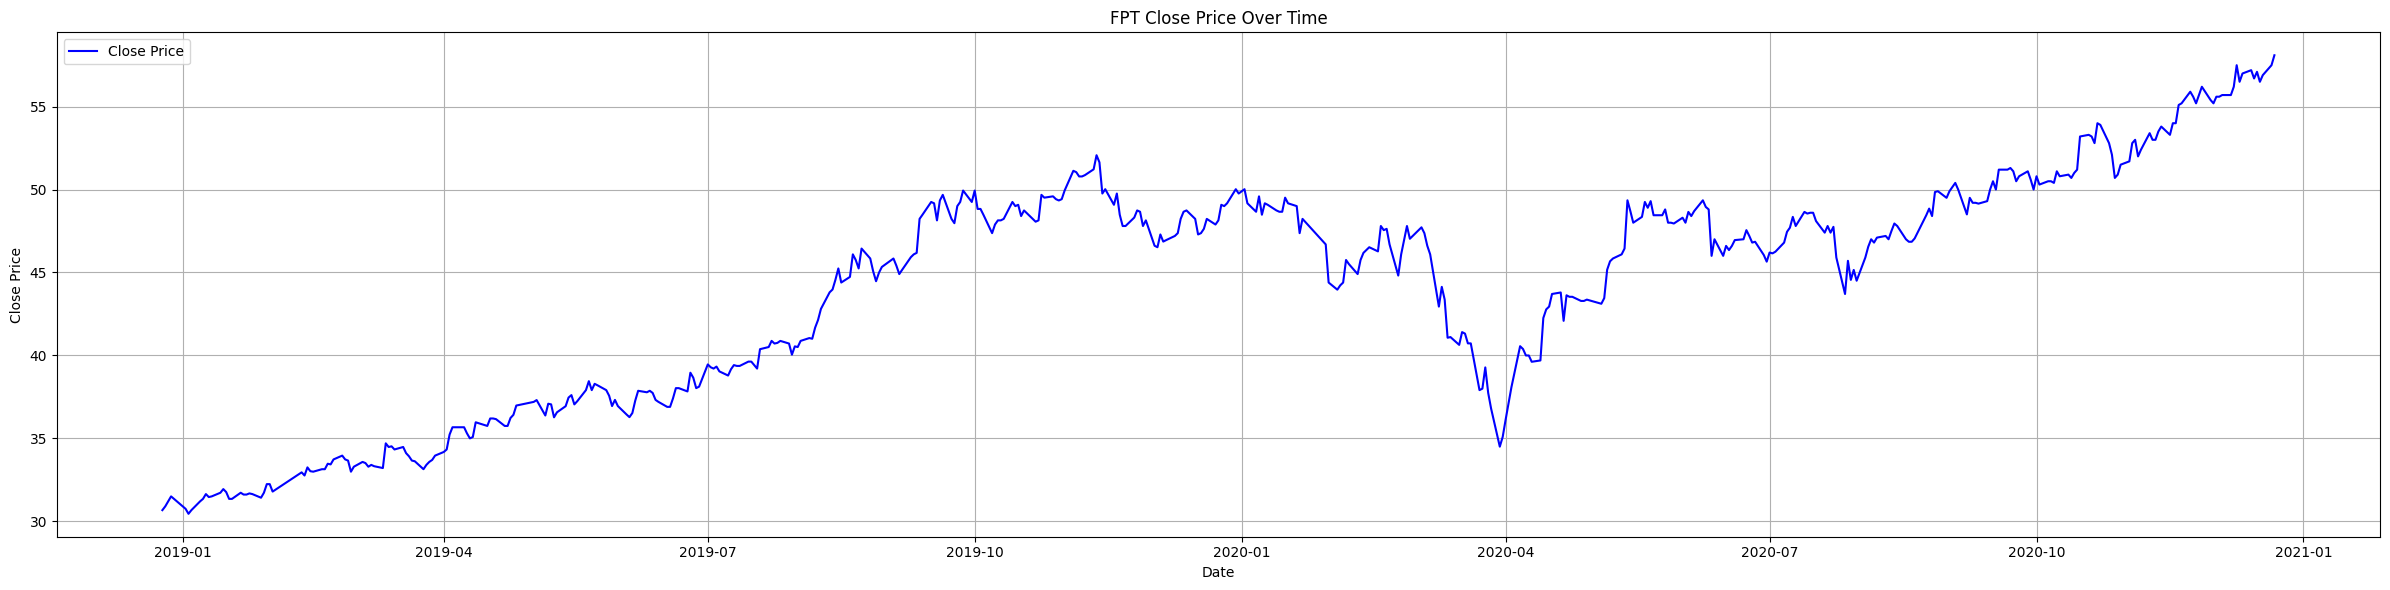

In [48]:
plt.figure(figsize=(24, 6))
plt.plot(FPT['Date'], FPT['Close'], label='Close Price', color='blue')
plt.title('FPT Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

- Giá cổ phiếu FPT nhìn chung có xu hướng tăng từ hơn 30.000/cổ phiếu đến gần 60.000/cổ phiếu.
- Giai đoạn đầu năm 2020 có sự biến động mạnh, giá giảm từ 48.000/cổ phiếu xuống còn 35.000/cổ phiếu. Điều này có thể do tác động của đại dịch COVID-19.

## 3. Volume over time

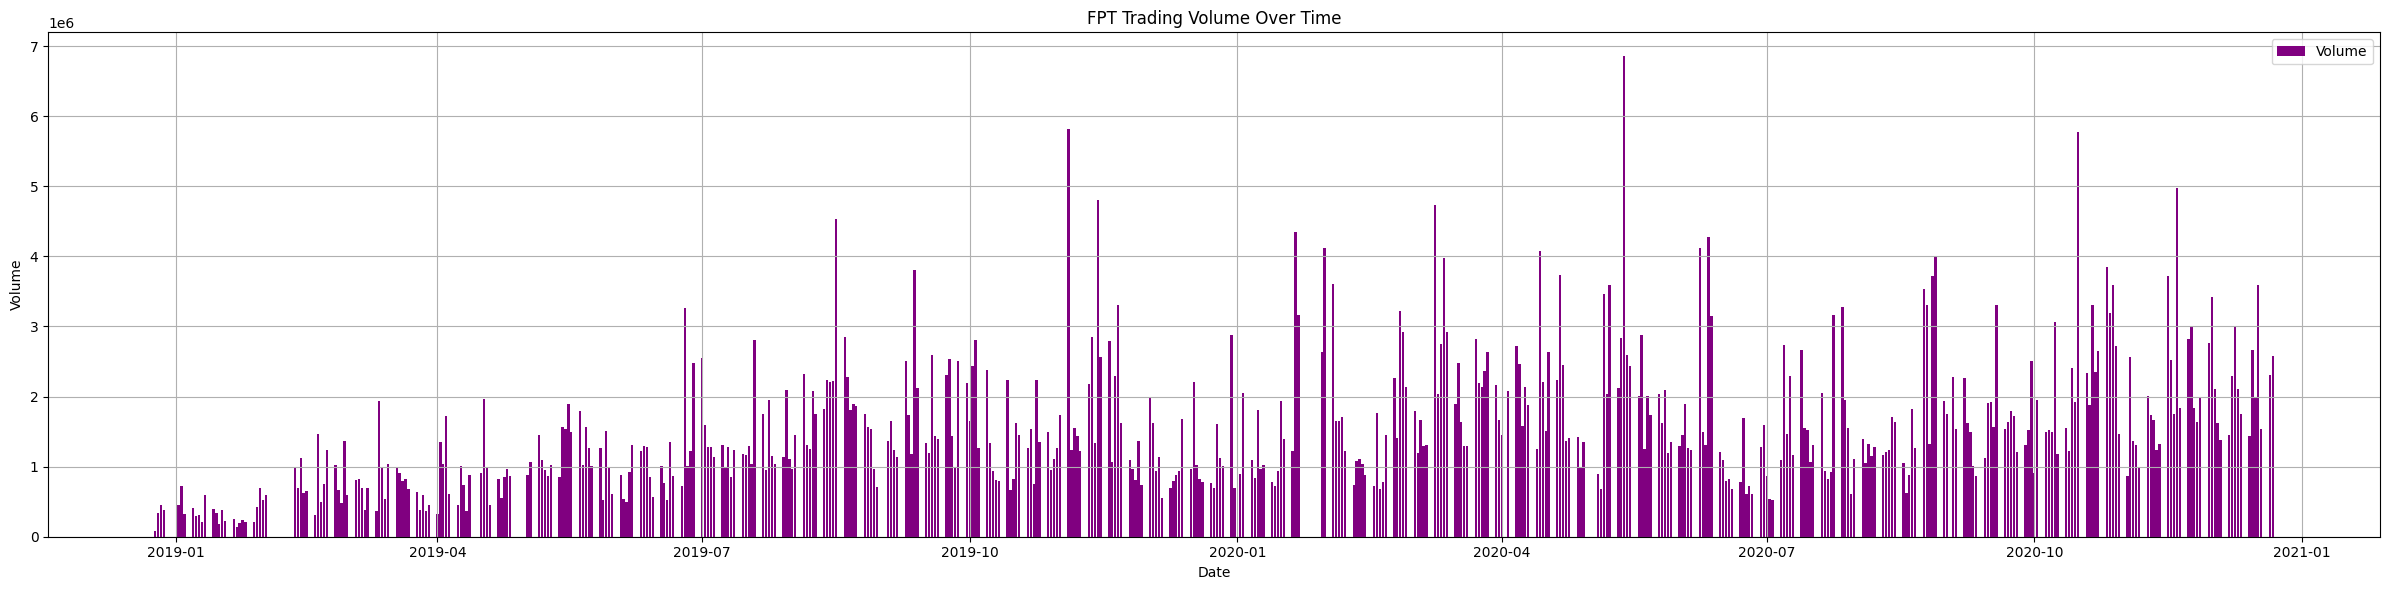

In [49]:
plt.figure(figsize=(24, 6))
plt.bar(FPT['Date'], FPT['Volume'], color='purple', label='Volume')
plt.title('FPT Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

- Volume có sự biến động mạnh và chênh lệch lớn giữa các ngày, do việc gộp dữ liệu ở trên.

## 4. Rate of return

In [50]:
from preprocessing import return_volatility_target

In [51]:
FPT = return_volatility_target(FPT)

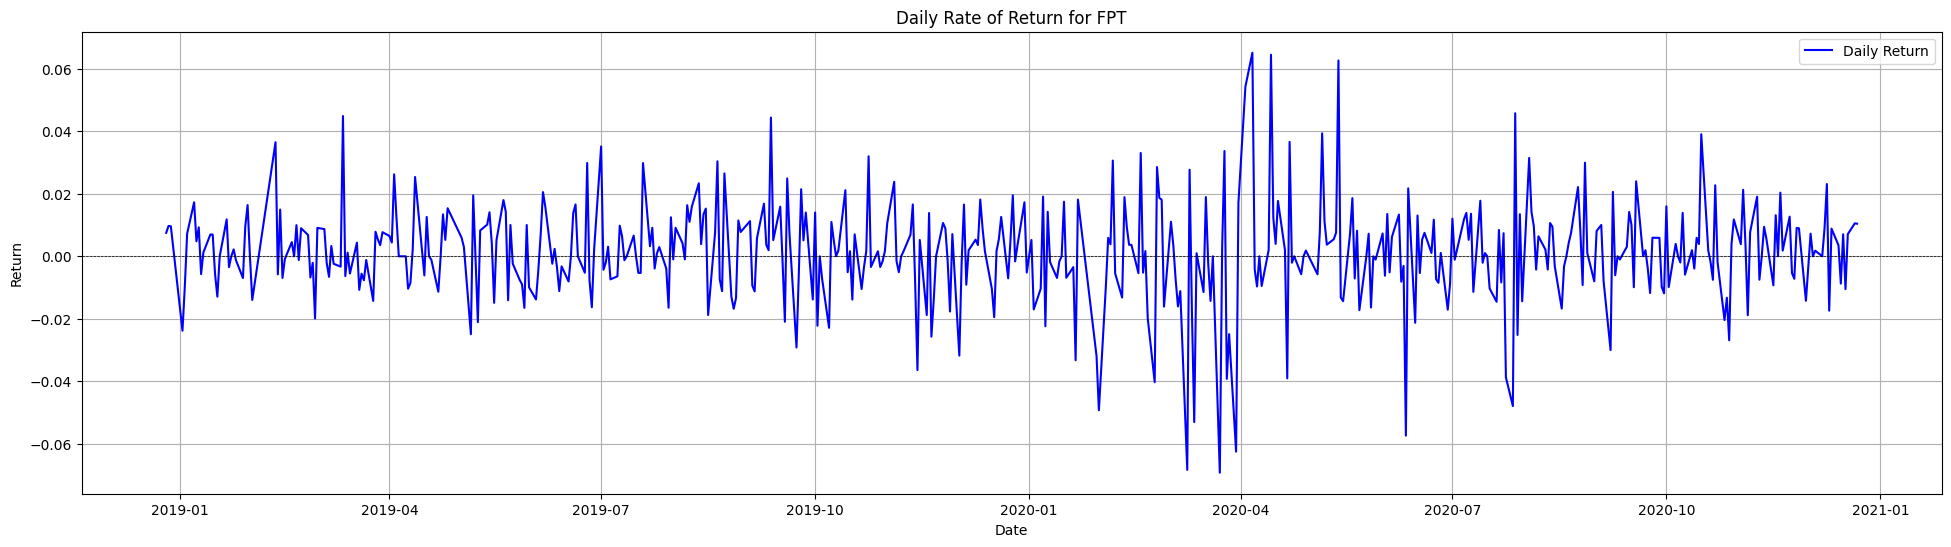

In [52]:
plt.figure(figsize=(24, 6))
plt.plot(FPT['Date'], FPT['Return'], label='Daily Return', color='blue')
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.title('Daily Rate of Return for FPT')
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend()
plt.grid(True)
plt.show()

- Lợi suất hàng ngày của cổ phiếu FPT dao động quanh mức 0, với nhiều biến động tăng giảm mạnh, đặc biệt là giai đoạn đầu 2020.
- Không có xu hướng rõ ràng trong dài hạn.

## 5. Volatility 

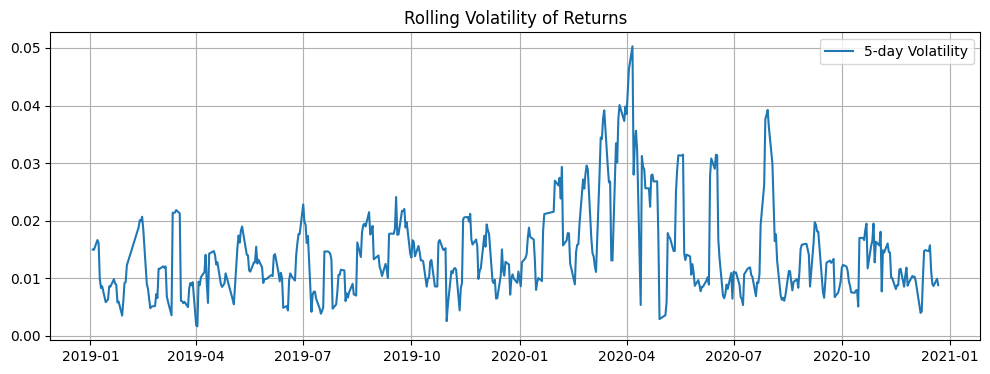

In [53]:
plt.figure(figsize=(12, 4))
plt.plot(FPT['Date'], FPT['volatility_5'], label='5-day Volatility')
plt.title('Rolling Volatility of Returns')
plt.grid(True)
plt.legend()
plt.show()

- Rolling volatility tăng đột biến trong quý 1–2 năm 2020, đạt đỉnh gần 5%, cho thấy mức độ rủi ro và bất ổn rất cao.
- Giai đoạn 2019, cuối 2020 có volatility thấp và ổn định, phản ánh thị trường yên ắng, ít cú sốc.

# III. Preprocessing data 

## 1. Removing Outliers 

In [54]:
from preprocessing import remove_outliers_and_plot

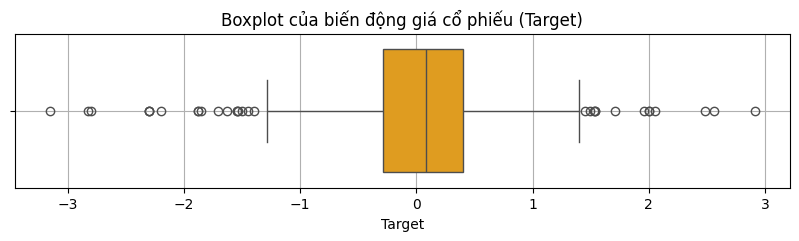

Số dòng còn lại sau khi loại outliers: 467


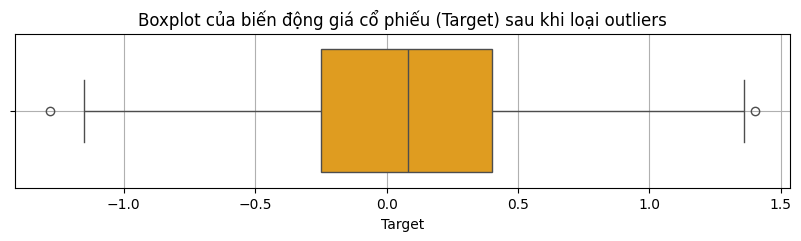

In [55]:
FPT = remove_outliers_and_plot(FPT)

- Thể hiện trên biểu đồ boxplot cho thấy có các giá trị outliers. Số lượng các giá trị này không quá nhiều (467 samples), nhưng nếu không loại bỏ có thể khiến model khó nắm bắt pattern. 
- Sau khi loại bỏ outliers, số lượng sample còn lại là 467.

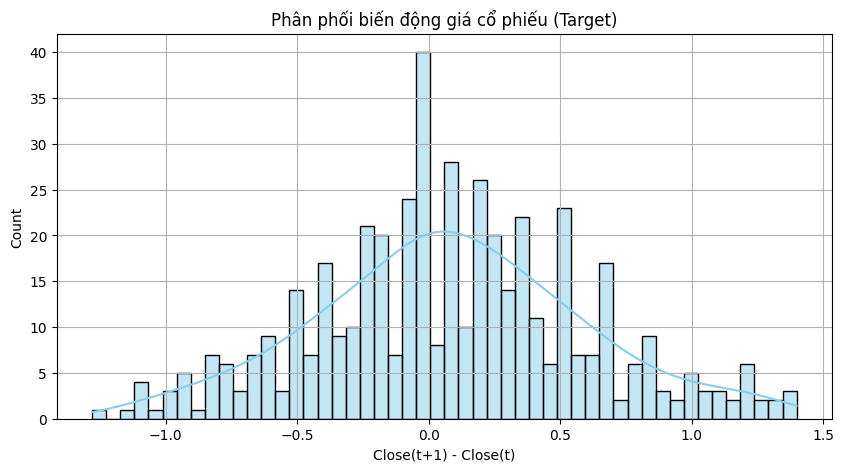

In [56]:
plt.figure(figsize=(10, 5))
sns.histplot(FPT['Target'], kde=True, bins=50, color='skyblue')
plt.title('Phân phối biến động giá cổ phiếu (Target)')
plt.xlabel('Close(t+1) - Close(t)')
plt.grid(True)
plt.show()

Sau khi xử lý loại bỏ outliers
- Distribution có hình dạng gần giống Normal Distribution.
- Center của distribution gần 0, nghĩa là phần lớn biến động hàng ngày của cổ phiếu là nhỏ.
- Nhưng có hiện tượng right-skewed nhẹ, cho thấy có một số ngày tăng giá mạnh, nhưng hiếm xảy ra.

## 2. Features engineering

- Thêm các features mới 

In [57]:
from preprocessing import feature_engineering

In [58]:
FPT = feature_engineering(FPT)

## 3. Data segregation

- Sau khi xử lý xong, data sẽ được chia thành các train, validate, test set để tiến hành train và evaluate model.

In [59]:
from data_segregation import split_time_series_data

In [60]:
features, target, X_trainval, X_test, y_trainval, y_test = split_time_series_data(FPT)

- Kiểm tra lại shape của dataset trước khi vào bước train model.

In [61]:
X_trainval.shape

(353, 33)

In [62]:
X_test.shape

(89, 33)

In [63]:
y_trainval.shape

(353,)

In [64]:
y_test.shape

(89,)

# IV. Model

## 1. Training

- Sử dụng model LightGBM để predict chênh lệch giá.

In [65]:
from data_segregation import time_series_cv

In [66]:
cv_model = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.05, random_state=42, verbosity=-1)

val_scores, val_preds, val_trues, val_dates = time_series_cv(
    model=cv_model,
    X=X_trainval,
    y=y_trainval,
    dates=FPT, 
    n_splits=3
)

In [67]:
from visualization import plot_cv_predictions

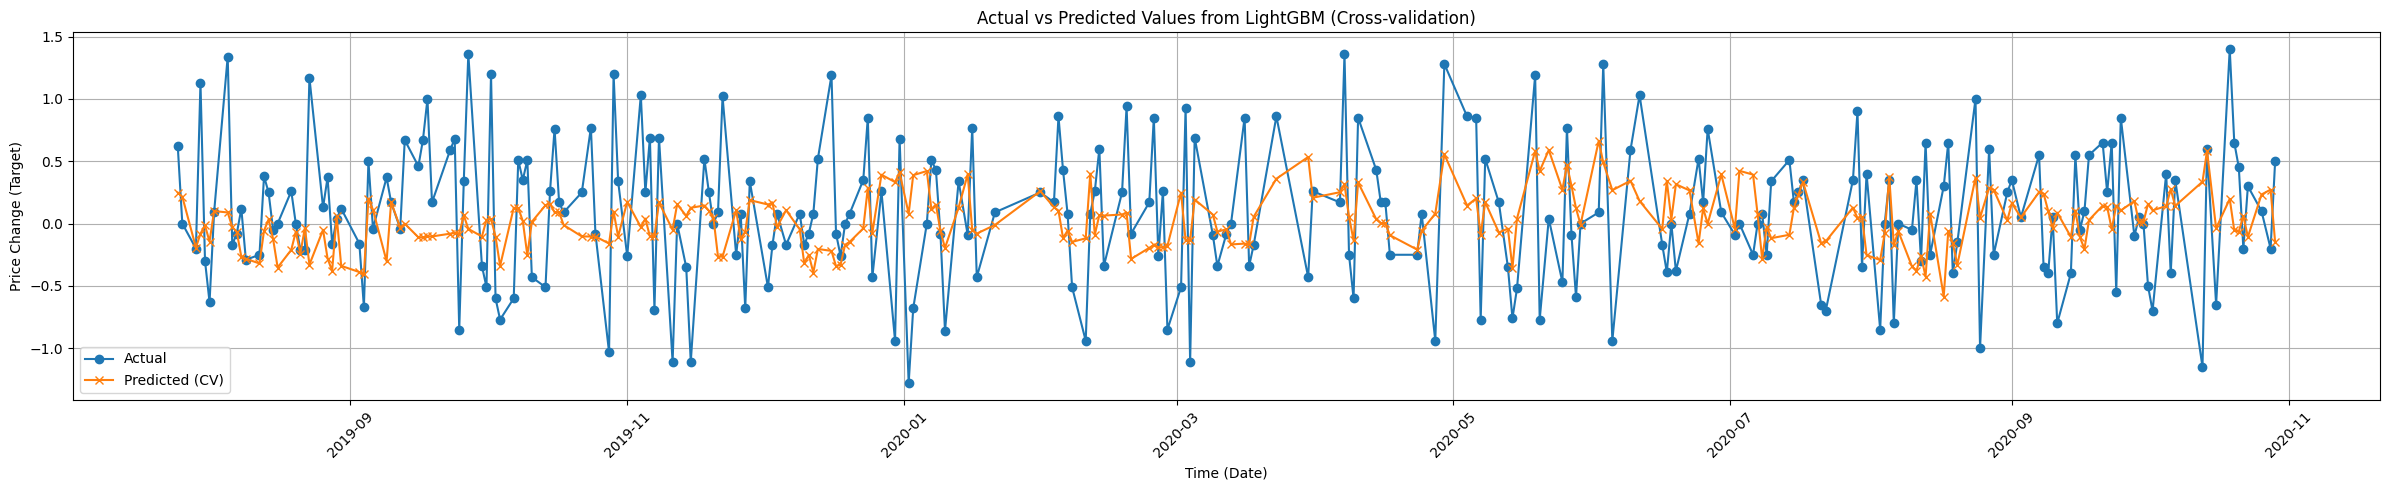

In [68]:
plot_cv_predictions(val_dates, val_trues, val_preds)

In [69]:
print(f"MAE trung bình (CV): {np.mean(val_scores):.4f}")

MAE trung bình (CV): 0.4551


- Đường Predicted khá phẳng, không giao động mạnh như đường Actual. Chứng tỏ model bắt được xu hướng nhưng biên độ nhỏ, không phản ứng đủ với các biến động lên/xuống của giá.
- Có dấu hiệu của underfitting. 
- MAE trên tập Cross-validation vào khoảng 0.45 cho thấy mô hình còn khá lệch với biến động thực tế. 

## 2. Tunning 

- Sử dụng Optuna để tìm bộ hyper-parameters tối ưu.
- Kết quả tối ưu được đánh giá trên tập Cross-validation.

In [70]:
from tunning import optuna_objective

In [71]:
objective = optuna_objective(X_trainval, y_trainval, loss_type="rmse_corr", n_splits=3)
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

best_params = study.best_params
print("Best hyperparameters:", best_params)

[I 2025-05-11 16:41:09,550] A new study created in memory with name: no-name-39135cc7-4479-4131-a0cb-f047820f4e3d
[I 2025-05-11 16:41:09,687] Trial 0 finished with value: 0.5598767981853473 and parameters: {'n_estimators': 115, 'learning_rate': 0.0792145734021839, 'max_depth': 10, 'num_leaves': 35, 'min_child_samples': 16, 'subsample': 0.7535399852317817, 'colsample_bytree': 0.9895669844558904}. Best is trial 0 with value: 0.5598767981853473.
[I 2025-05-11 16:41:09,769] Trial 1 finished with value: 0.5166099652053674 and parameters: {'n_estimators': 138, 'learning_rate': 0.08326861911789521, 'max_depth': 8, 'num_leaves': 46, 'min_child_samples': 22, 'subsample': 0.8925901235363157, 'colsample_bytree': 0.8360593790826039}. Best is trial 1 with value: 0.5166099652053674.
[I 2025-05-11 16:41:09,896] Trial 2 finished with value: 0.5663854440925106 and parameters: {'n_estimators': 199, 'learning_rate': 0.1481915726410425, 'max_depth': 9, 'num_leaves': 72, 'min_child_samples': 17, 'subsample

Best hyperparameters: {'n_estimators': 112, 'learning_rate': 0.020084836446035755, 'max_depth': 7, 'num_leaves': 77, 'min_child_samples': 24, 'subsample': 0.9107701165779171, 'colsample_bytree': 0.9727537549221922}


## 3. Retraining and fetures importance

- Model sẽ được train lại một lần nữa với toàn bộ tập train và bộ hyper-parameter tối ưu vừa tìm được. 

In [72]:
best_model = lgb.LGBMRegressor(**best_params)
best_model.fit(X_trainval, y_trainval)

y_pred_test = best_model.predict(X_test)

In [73]:
importances = best_model.feature_importances_
feat_names = features.columns
feat_df = pd.DataFrame({'Feature': feat_names, 'Importance': importances})
feat_df = feat_df.sort_values(by='Importance', ascending=False)
print(feat_df.head(10))

           Feature  Importance
29   Open_to_Close         118
5           Return          92
26    Volume_avg_5          85
28  Intraday_range          80
14         Day_sin          71
24    Close_vs_MA5          54
31            MACD          50
30             RSI          49
7     volatility_5          44
21            MA_5          41


- Các features được thêm vào có vai trò khá quan trọng, khi model dựa nhiều vào các features này để đưa ra quyết định.
- Các features có đóng góp nhiều nhất gồm: Open_to_Close, Return, Intraday_range, Volume_avg_5, Close_vs_MA5, Day_sin, Volume_spike, Day_cos, RSI, Volatility_20.

In [74]:
from visualization import plot_test_predictions

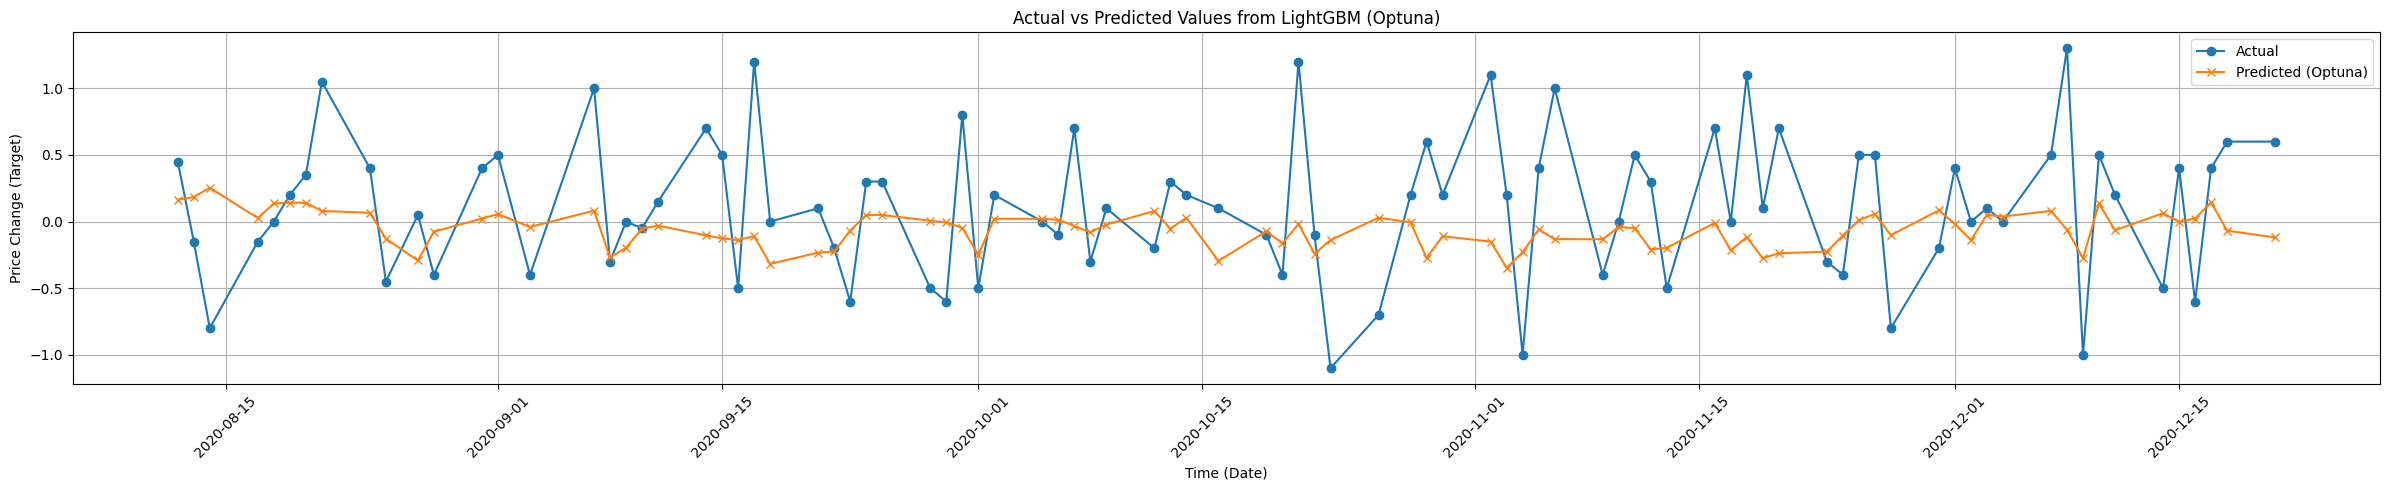

In [75]:
plot_test_predictions(FPT.loc[y_test.index, 'Date'].values, y_test.values, y_pred_test)

In [77]:
mse = mean_squared_error(y_test, y_pred_test)
mae = mean_absolute_error(y_test, y_pred_test)
rmse = np.sqrt(mse)

print(f"[Final Result]")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

[Final Result]
MAE: 0.4486
RMSE: 0.5577


- Mặc dù kết quả MAE sau khi tối ưu có cải thiện nhưng khả năng bắt trend pattern của model giảm rõ rệt.
- Có hiện tượng underfitting.